<a href="https://colab.research.google.com/github/jedhouas/Advanced-Deep-Learning/blob/master/TP4_active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning Practical

Active Learning is generally useful in a specific case of small data: when unlabelled data is plentiful, but labelling it is costly. Think for example that each example must be analysed by an expert for labelling it. Expert time is costly, so we would like to be able to train a successful classifier while labelling as few examples as possible.

Active Learning is an approach to answer this problem. The general principle is the following: we first randomly ask the expert to label a small random subset of the training data, and train our classifier on it. Once this first step is done, we can analyse the behaviour of our trained model on the yet unlabelled data, to deduce which additional examples would be worth labelling to improve the quality of the model as quickly as possible. We then retrain the model on the new larger labelled dataset and iterate this process, labelling more and more examples, until we reach a satisfying performance. And hopefully reaching it while only labelling a small fraction of the whole available dataset.

The main question in Active Learning is thus the following: How should we choose the next batch of examples to be labelled?

There are different strategies for this, that you will compare in this practical.

### Example setup

We will emulate an active learning situation using the MNIST dataset, starting by pretending we don't have the labels. The "ask an expert to label the example" step will thus be simply picking the label from the dataset.

You'll have to provide a neural network architecture and the implementation of various active learning strategies, with the goal of comparing them. Keep in mind that the start of the training will be on very small datasets when designing your architectures.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np

import random

import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
if torch.cuda.is_available :
  device=torch.device('cuda')
else:
  device=torch.device('cpu')

In [0]:
# Loading MNIST dataset from torchvision.dataset
original_mnist = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)



Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [0]:
# This function creates an unlabelled dataset based on the MNIST images
#
# All examples that are not yet labelled have a label set to -1
def unlabeled_dataset():
    return TensorDataset(
        original_mnist.data[5000:].float() * 2.0 / 255.0 -1.0,
        torch.zeros_like(original_mnist.targets[5000:]) - 1
    )

# This function labels the requested examples on an unlabelled dataset
def call_expert(dataset, indices):
    for i in indices:
        dataset.tensors[1][i] = original_mnist.targets[5000+i]

# Keep 5000 examples as a validation
mnist_validation = TensorDataset(
    original_mnist.data[:5000].float() * 2.0 / 255.0 -1.0,
    original_mnist.targets[:5000]
)

You can here define your model that will be used for the Active learning process:

In [0]:
class Model(nn.Module):
    def __init__(self):
      super(Model, self).__init__()

      self.conv1 = nn.Sequential(
          nn.Conv2d(1, 128, 5, padding=1,stride=2),nn.ReLU(),nn.BatchNorm2d(128),
          nn.Conv2d(128, 64, 3, padding=1),nn.ReLU(),nn.BatchNorm2d(64),
          nn.MaxPool2d(2, 2),
          nn.Conv2d(64, 64, 3, padding=1),nn.ReLU(),nn.BatchNorm2d(64),
          nn.Conv2d(64, 32, 3, padding=1),nn.ReLU(),nn.BatchNorm2d(32),
          nn.MaxPool2d(2, 2)
      )
      
      self.lin = nn.Sequential(
          nn.Linear(288, 10)
      )

    def forward(self, x):
      x=x.unsqueeze(1)
      x = self.conv1(x)
      x = x.view(x.size(0), -1)
      return self.lin(x)

And here are the learning hyper-parameters, as for the previous practicals you may need to tinker with them:

In [0]:
# number of times the expert will be called to label a batch of examples
num_active_runs = 20

# number of training iterations between each expert call
# the number of epochs is thus num_iter * batch_size / len(dataset)
num_iter = 100
batch_size = 64


criterion = nn.CrossEntropyLoss()

learning_rate = 0.01

Now is the place where you define the strategy to choose the next examples to label. A strategy is a function taking as input your model and the dataset, and returning a list of examples to label.

You can create several functions to test different strategies.

## Please see comments in the below code

In [0]:
# We have modified the random strategy in order to select randomly from the unlabelled dataset only and not the whole dataset.
# We have also added the option to compared adding 20 and adding 80 labels to see the impact of the number of added labels.

def random_strategy(model, dataset, nb_new_examp):
    # label 20 new examples at random
    unlabelled = dataset.tensors[1] < 0
    unlabelled_idx = np.argwhere(unlabelled == True).squeeze(0)
    return torch.tensor(np.random.choice(unlabelled_idx, nb_new_examp, replace=False))


# Entropy selection strategy will add at each iteration labels to the unlebbeled samples where the prediction has the biggest
# entropy, ie where predictions are most uncertain. The number of added labels in an input of the function.

def entropy_selection(model, dataset, nb_new_examp):
    # implement your strategies as new functions here
    unlabelled = dataset.tensors[1] < 0
    unlabelledDataSet = TensorDataset(*list(t[unlabelled] for t in dataset.tensors))
    loader = DataLoader(unlabelledDataSet, batch_size=batch_size, shuffle=False)
    prediction =[]
    with torch.no_grad():
        for (data, targets) in loader:
            pred = F.softmax(model(data.to(device)))
            prediction = prediction + pred.tolist()
    prediction_arr = np.array(prediction)
    e = (-prediction_arr * np.log2(prediction_arr)).sum(axis=1)
    selection = (np.argsort(e)[::-1])[:nb_new_examp]
    return selection

# Margin selection strategy will add at each iteration labels to the unlebbeled samples where the difference between the two
# hihgest classes in terms of probabilitiy is the smallest, which reflects that we are highly uncertain in their predictoion.
# This function also takes the number of added labels as input.

def margin_selection(model, dataset, nb_new_examp):
  unlabelled = dataset.tensors[1] < 0
  unlabelledDataSet = TensorDataset(*list(t[unlabelled] for t in dataset.tensors))
  loader = DataLoader(unlabelledDataSet, batch_size=batch_size, shuffle=False)
  prediction =[]
  with torch.no_grad():
      for (data, targets) in loader:
          pred = F.softmax(model(data.to(device)))
          prediction = prediction + pred.tolist()
  prediction_arr = np.array(prediction)
  rev = np.sort(prediction_arr, axis=1)[:, ::-1]
  values = rev[:, 0] - rev[:, 1]
  selection = np.argsort(values)[:nb_new_examp]
  return selection


This function is the main training loop, the only part you should need to modify is the initialization of the optimizer (noted by the `# OPTIMIZER` comment).

Don't forget to reload this cell whenever you change the hyper-parameters.

In [0]:
# returns a tensor of values:
# - output[:,0] are the number of labeled examples
# - output[:,1] are the associated accuracies
# - output[:,2] are the associated losses
def active_training(strategy, dataset=None, initial_labeling=20, nb_new_examp = 20):
    if dataset is None:
        dataset = unlabeled_dataset()
        call_expert(dataset, torch.randint(0, len(dataset), (initial_labeling,)))
    
    def train_model(model, optimizer, loader, epochs):
        for _ in range(epochs):
            for (data, targets) in loader:
              data, targets = data.to(device), targets.long().to(device)
              model.zero_grad()
              prediction = model(data)
              loss = criterion(prediction, targets)
              loss.backward()
              optimizer.step()
    
    def validation_perf(model, dataset):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        total_accuracy = 0.0
        total_loss = 0.0
        with torch.no_grad():
            for (data, targets) in loader:
                prediction = model(data.to(device))
                total_loss += criterion(prediction.cpu(), targets).item() * data.size(0)
                _, number_predicted = torch.max(prediction.data, 1)
                total_accuracy += (number_predicted.cpu() == targets).sum()
        return (total_accuracy / len(dataset), total_loss / len(dataset))
    
    nb_epochs = int(500/nb_new_examp)
    performances = torch.zeros(nb_epochs+1, 3)
    for i in range(nb_epochs+1):
        # filter the dataset to only keep labelled examples
        labelled_idx = dataset.tensors[1] >= 0
        filtered_dataset = TensorDataset(*list(t[labelled_idx] for t in dataset.tensors))
        loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)
        # create a new model to train on this dataset
        model = Model()
        model.to(device)
        # OPTIMIZER
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, optimizer, loader, num_iter // len(loader))
        (valid_acc, valid_loss) = validation_perf(model, mnist_validation)
        
        performances[i, 0] = len(filtered_dataset)
        performances[i, 1] = valid_acc
        performances[i, 2] = valid_loss
        print("With {} examples, valid perf (loss and accuracy) is: {} -- {}%".format(len(filtered_dataset), valid_loss, valid_acc*100))
        if i < nb_epochs:
          to_label = strategy(model, dataset,nb_new_examp)
          call_expert(dataset, to_label)
  
    return performances

The following cells contain code that you can use to compare your different strategies. Fill the `strategies` list with the name of the functions implementing your strategies, and run the cell to compare them.

In [0]:
# a list of strategies you want to compare
strategies = [random_strategy,entropy_selection,margin_selection]
list_nb_new_examp = [20,80]
# number of examples to label randomly at the start
initial_labeling = 20

performances = []
for strat in strategies:
  for nb_new_examp in list_nb_new_examp:
    print("Training with strategy: {}_{}".format(strat.__name__,str(nb_new_examp)))
    perf = active_training(strat, dataset=None, initial_labeling=initial_labeling, nb_new_examp = nb_new_examp)
    performances.append((strat.__name__+"_"+str(nb_new_examp), perf))
print("done")

Training with strategy: random_strategy_20
With 20 examples, valid perf (loss and accuracy) is: 2.61359605178833 -- 55.040000915527344%
With 40 examples, valid perf (loss and accuracy) is: 1.835343818473816 -- 60.46000289916992%
With 60 examples, valid perf (loss and accuracy) is: 1.1012935423851014 -- 75.8800048828125%
With 80 examples, valid perf (loss and accuracy) is: 0.8496147089958191 -- 78.6199951171875%
With 100 examples, valid perf (loss and accuracy) is: 0.6240722536355257 -- 84.16000366210938%
With 120 examples, valid perf (loss and accuracy) is: 0.45764476234801116 -- 89.02000427246094%
With 140 examples, valid perf (loss and accuracy) is: 0.6429429033756257 -- 85.25999450683594%
With 160 examples, valid perf (loss and accuracy) is: 0.413716462290287 -- 89.0999984741211%
With 180 examples, valid perf (loss and accuracy) is: 0.31667670016810295 -- 91.36000061035156%
With 200 examples, valid perf (loss and accuracy) is: 0.34460782385878264 -- 91.08000183105469%
With 220 examp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


With 40 examples, valid perf (loss and accuracy) is: 2.9466750968933106 -- 53.46000289916992%
With 60 examples, valid perf (loss and accuracy) is: 1.5473784351348876 -- 66.55999755859375%
With 80 examples, valid perf (loss and accuracy) is: 0.6302794242858887 -- 82.22000122070312%
With 100 examples, valid perf (loss and accuracy) is: 0.6090453327178955 -- 82.9800033569336%
With 120 examples, valid perf (loss and accuracy) is: 0.5815161129951477 -- 84.69999694824219%
With 140 examples, valid perf (loss and accuracy) is: 0.5345922622680664 -- 86.22000122070312%
With 159 examples, valid perf (loss and accuracy) is: 0.43187158977985385 -- 88.80000305175781%
With 179 examples, valid perf (loss and accuracy) is: 0.41097072520256045 -- 89.4800033569336%
With 199 examples, valid perf (loss and accuracy) is: 0.4039347834348679 -- 90.86000061035156%
With 219 examples, valid perf (loss and accuracy) is: 0.3448693210303783 -- 91.27999877929688%
With 239 examples, valid perf (loss and accuracy) is:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


With 40 examples, valid perf (loss and accuracy) is: 1.7325681053161621 -- 68.66000366210938%
With 60 examples, valid perf (loss and accuracy) is: 0.952335675239563 -- 77.54000091552734%
With 80 examples, valid perf (loss and accuracy) is: 0.7591902766227722 -- 81.12000274658203%
With 100 examples, valid perf (loss and accuracy) is: 0.6917615578532219 -- 82.0999984741211%
With 120 examples, valid perf (loss and accuracy) is: 0.4324185908079147 -- 88.34000396728516%
With 140 examples, valid perf (loss and accuracy) is: 0.4070134404912591 -- 89.24000549316406%
With 160 examples, valid perf (loss and accuracy) is: 0.3438652633547783 -- 91.0999984741211%
With 180 examples, valid perf (loss and accuracy) is: 0.298984805957973 -- 91.54000091552734%
With 200 examples, valid perf (loss and accuracy) is: 0.2948331019461155 -- 92.15999603271484%
With 220 examples, valid perf (loss and accuracy) is: 0.30628769874572753 -- 92.13999938964844%
With 240 examples, valid perf (loss and accuracy) is: 0.

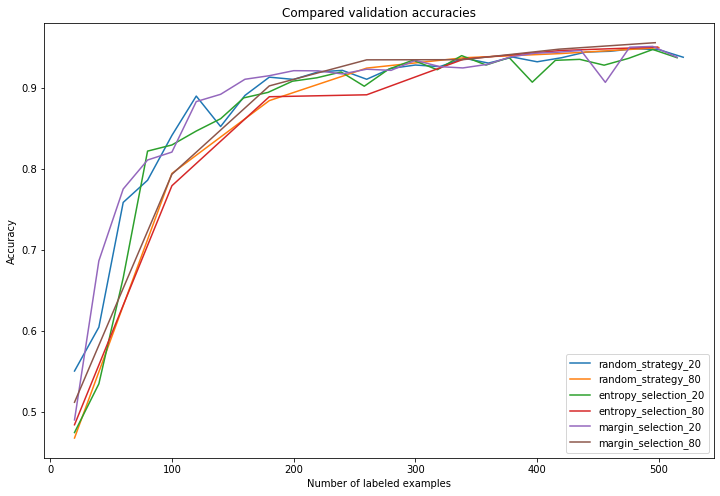

In [0]:
plt.figure(figsize=(12,8))
plt.title("Compared validation accuracies")
plt.xlabel("Number of labeled examples")
plt.ylabel("Accuracy")
for (name, perf) in performances:
    plt.plot(perf[:,0], perf[:,1], label=name)
plt.legend(loc='lower right')
plt.show()

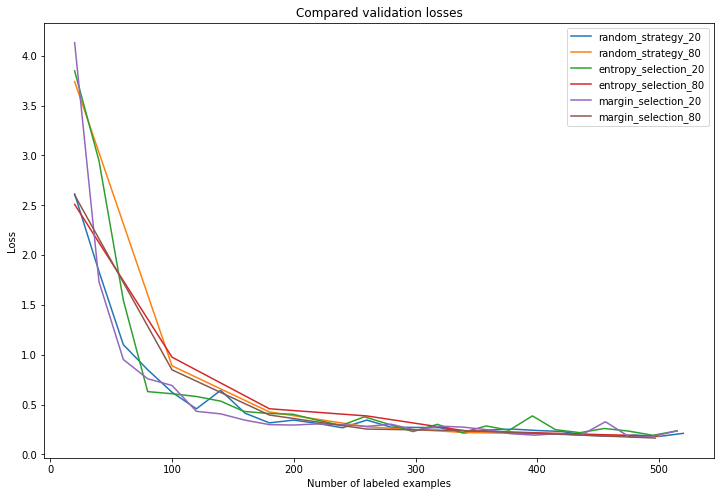

In [0]:
plt.figure(figsize=(12,8))
plt.title("Compared validation losses")
plt.xlabel("Number of labeled examples")
plt.ylabel("Loss")
for (name, perf) in performances:
    plt.plot(perf[:,0], perf[:,2], label=name)
plt.legend(loc='upper right')
plt.show()

### Results commentary:

First we need to pay attention to the fact that the best strategy will depend greatly on the model and the prediction problem we are solving.
The results we get are pretty similar between the different strategies, We are able to reach 95% validation accuracy in less than 500 samples. This might be due to the simplistic problem in hand and to the predictive capacity of the model we implemented. However Margin selection strategy perfroms better overall: we can see that when we added fewer samples (20), margin selection highly outperformed the other strategies in the beginning. It also converged to better overall accuracy of 94.8% under 400 samples when we added more samples (80).

The provided code only implement the "random" strategy, which chooses examples at random to label them. Your task is to compare it to other, more guided strategies. For example:

- a strategy that would label in priority the examples for which the classifier is the most uncertain, as measured by the entropy of its output
- a strategy that would label in priority the examples that appear to be near the frontier between the classes: examples for which the highest and second-highest prediction values of the classifier are close to each other.

You can also try to use other relevant decision criterion for choosing which examples to label, and implement them as new strategies. It is also possible to combine strategies together, in order to combine the strong points of each of them.

**Some advice:**

Keep in mind that your goal is to reach the best possible validation accuracy with as little labelled training examples as possible. As such, don't forget to try and change the number of initial examples for labelling, as well as the number of examples your strategy will request for labelling at each round.

Also keep in mind that you network will be trained on possibly very small datasets (think of only a few hundred of examples), while the validation set contains 5000 examples. Be careful of the risks of over-fitting, adjust your network structure and the training time (`num_iter`) appropriately.

As a baseline, you should be able to reach at least 90% of validation accuracy with less than 500 labelled examples.

**When you are done, you're asked to upload this notebook with your model, the different strategies your compared with the graphs generated by the previous code. Your strategies functions should be commented to explain what each strategy does, and which one is your best strategy.**